In [4]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [5]:
raw_recipes = pd.read_csv("RAW_recipes.csv")
raw_interactions = pd.read_csv("RAW_interactions.csv")
#pp_recipes = pd.read_csv("data/PP_recipes.csv")
#pp_users = pd.read_csv("data/PP_users.csv")
#ingr_map = pd.read_pickle("data/ingr_map.pkl")

In [12]:
ratings = raw_interactions[["user_id", "recipe_id", "rating"]]
ratings.columns

Index(['user_id', 'recipe_id', 'rating'], dtype='object')

In [8]:
dishes = raw_recipes[["id", "name"]]

In [10]:
dishes.columns

Index(['id', 'name'], dtype='object')

In [15]:
df = pd.merge(dishes, ratings, left_on='id', right_on='recipe_id')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   id         1132367 non-null  int64 
 1   name       1132366 non-null  object
 2   user_id    1132367 non-null  int64 
 3   recipe_id  1132367 non-null  int64 
 4   rating     1132367 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 43.2+ MB


In [5]:
df = pd.merge(ratings, dishes, on='recipe_id', how='inner')

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 493409 to 396683
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1132367 non-null  int64  
 1   recipe_id  1132367 non-null  int64  
 2   rating     1132367 non-null  float32
 3   name       1132366 non-null  object 
 4   user       1132367 non-null  int64  
 5   recipe     1132367 non-null  int64  
dtypes: float32(1), int64(4), object(1)
memory usage: 56.2+ MB


In [16]:
user_ids = df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
recipe_ids = df["recipe_id"].unique().tolist()
recipe2recipe_encoded = {x: i for i, x in enumerate(recipe_ids)}
recipe_encoded2recipe = {i: x for i, x in enumerate(recipe_ids)}
df["user"] = df["user_id"].map(user2user_encoded)
df["recipe"] = df["recipe_id"].map(recipe2recipe_encoded)

num_users = len(user2user_encoded)
num_recipes = len(recipe_encoded2recipe)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Recipes: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_recipes, min_rating, max_rating
    )
)

Number of users: 226570, Number of Recipes: 231637, Min rating: 0.0, Max rating: 5.0


In [17]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "recipe"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [22]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_recipes, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_recipes = num_recipes
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.recipe_embedding = layers.Embedding(
            num_recipes,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.recipe_bias = layers.Embedding(num_recipes, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        recipe_vector = self.recipe_embedding(inputs[:, 1])
        recipe_bias = self.recipe_bias(inputs[:, 1])
        dot_user_recipe = tf.tensordot(user_vector, recipe_vector, 2)
        # Add all the components (including bias)
        x = dot_user_recipe + user_bias + recipe_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_recipes, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

In [23]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=10000,
    epochs=15,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/15
102/102 [==============================] - 30s 277ms/step - loss: 0.4898 - val_loss: 0.3644
Epoch 2/15
102/102 [==============================] - 27s 268ms/step - loss: 0.4500 - val_loss: 0.6310
Epoch 3/15
102/102 [==============================] - 27s 267ms/step - loss: 0.4279 - val_loss: 0.6049
Epoch 4/15
102/102 [==============================] - 27s 269ms/step - loss: 0.3863 - val_loss: 0.5182
Epoch 5/15
102/102 [==============================] - 28s 271ms/step - loss: 0.4112 - val_loss: 0.7341
Epoch 6/15
102/102 [==============================] - 28s 273ms/step - loss: 4.5440 - val_loss: 0.7633
Epoch 7/15
102/102 [==============================] - 28s 270ms/step - loss: 6.8929 - val_loss: 0.6354
Epoch 8/15
102/102 [==============================] - 28s 270ms/step - loss: 4.8455 - val_loss: 0.4281
Epoch 9/15
102/102 [==============================] - 27s 268ms/step - loss: 3.2221 - val_loss: 0.6485
Epoch 10/15
102/102 [==============================] - 27s 269ms/step - l

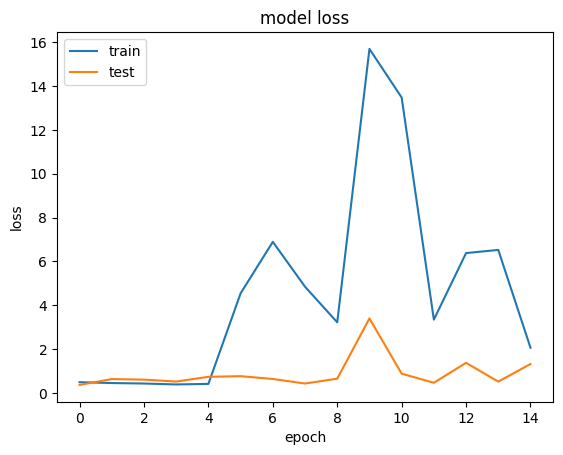

In [24]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [35]:
user_id = df.user_id.sample(1).iloc[0]
recipes_made_by_user = df[df.user_id == user_id]
recipes_not_made = df[
    ~df["recipe_id"].isin(recipes_made_by_user.recipe_id.values)
]["recipe_id"]

In [26]:
recipes_not_made.shape()

TypeError: 'tuple' object is not callable

In [28]:
pp_recipes = pd.read_csv("PP_recipes.csv")

In [36]:
recipes_not_made = pp_recipes[
    ~pp_recipes["id"].isin(recipes_made_by_user.recipe_id.values)
]["id"]

In [37]:
recipes_not_made = list(
    set(recipes_not_made).intersection(set(recipe2recipe_encoded.keys()))
)
recipes_not_made = [[recipe2recipe_encoded.get(x)] for x in recipes_not_made]
user_encoder = user2user_encoded.get(user_id)
user_recipe_array = np.hstack(
    ([[user_encoder]] * len(recipes_not_made), recipes_not_made)
)
ratings = model.predict(user_recipe_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_recipe_ids = [
    recipe_encoded2recipe.get(recipes_not_made[x][0]) for x in top_ratings_indices
]

5569/5569 [==============================] - 14s 3ms/step


In [38]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Recipes with high ratings from user")
print("----" * 8)
top_recipes_user = (
    recipes_made_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .recipe_id.values
)
recipe_df_rows = df[df["recipe_id"].isin(top_recipes_user)]
i=0
for row in recipe_df_rows.itertuples():
    if i>6:
        break
    print(row.name)
    i=i+1

print("----" * 8)
print("Top 10 recipe recommendations")
print("----" * 8)
recommended_recipes = df[df["recipe_id"].isin(recommended_recipe_ids)]
i=0
for row in recommended_recipes.itertuples():
    if i>10:
        break
    print(row.name)
    i=i+1

Showing recommendations for user: 91340
Recipes with high ratings from user
--------------------------------
papaya and mango with mango cream
apple enchiladas
apple enchiladas
apple enchiladas
apple enchiladas
apple enchiladas
apple enchiladas
--------------------------------
Top 10 recipe recommendations
--------------------------------
crumb topped banana muffins
kittencal s italian melt in your mouth meatballs
brown sugar bundt cake
kittencal s italian melt in your mouth meatballs
so it s bekah s pulled pork now
my chicken parmigiana
kittencal s italian melt in your mouth meatballs
kittencal s easy and delicious ranch parmesan chicken
kittencal s italian melt in your mouth meatballs
brown sugar bundt cake
kittencal s italian melt in your mouth meatballs
